# CNN-colorized model

Code used from: https://www.kaggle.com/code/adithyakag/image-colorization-cnn/notebook

In [1]:
# Import required libraries
%matplotlib inline
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 
import cv2
import os

In [2]:
# Firstly we just load our images in matrix view(only 2500 at this point)
gray_images = np.load('l/gray_scale.npy')[:2500]
images_colors = np.load('ab/ab/ab1.npy')[:2500]

In [3]:
# Example of data for gray picture
gray_images[0]

array([[237, 135,  75, ...,  35,  37,  63],
       [234, 152,  72, ...,  41,  49,  47],
       [215, 216, 104, ...,  73,  48,  82],
       ...,
       [ 40,  45,  38, ...,  11,   8,   8],
       [ 40,  56,  47, ...,   8,   7,  10],
       [ 42,  60,  79, ...,  12,  13,  15]], dtype=uint8)

In [4]:
# Example of data for colors for pictures
images_colors[0]

array([[[129, 136],
        [126, 134],
        [126, 135],
        ...,
        [125, 132],
        [124, 134],
        [124, 135]],

       [[127, 137],
        [126, 136],
        [126, 133],
        ...,
        [127, 131],
        [125, 133],
        [123, 137]],

       [[127, 138],
        [127, 134],
        [127, 134],
        ...,
        [125, 131],
        [126, 131],
        [128, 133]],

       ...,

       [[126, 131],
        [126, 131],
        [127, 131],
        ...,
        [126, 130],
        [126, 130],
        [126, 130]],

       [[126, 131],
        [127, 131],
        [126, 132],
        ...,
        [126, 130],
        [126, 130],
        [126, 130]],

       [[127, 131],
        [127, 133],
        [128, 135],
        ...,
        [126, 130],
        [124, 130],
        [126, 130]]], dtype=uint8)

Start with preprocessing part.

In [5]:
# Process data from initial view into type which I can show and put it in the model using first dataset
def pipe_line_img(gray_scale_imgs, preprocess_f = preprocess_input):
    # Initialize an empty array with the correct shape
    imgs = np.zeros((len(gray_scale_imgs), 224, 224, 3))

    # Process each image
    for i in range(len(gray_scale_imgs)):
        for j in range(3):
            imgs[i, :, :, j] = gray_scale_imgs[i]

    return preprocess_f(imgs)

imgs_for_input = pipe_line_img(gray_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


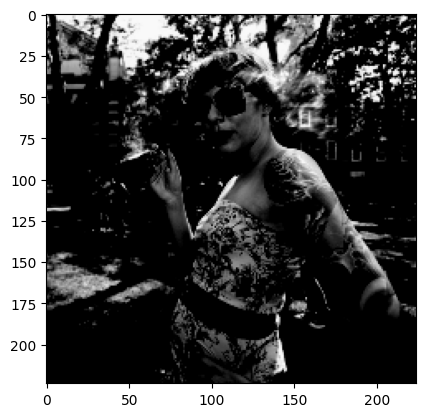

In [6]:
# Example of gray picture
plt.imshow(imgs_for_input[0])

In [8]:
# Process data from initial view into type which I can show and put it in the model using both datasets
def get_rbg_from_lab(gray_imgs, ab_imgs):
    
    #create an empty array to store images
    n = len(gray_imgs)
    imgs = np.zeros((n, 224, 224, 3))
    
    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]
    
    #convert all the images to type unit8
    imgs = imgs.astype("uint8")
    
    #create a new empty array
    imgs_ = []
    
    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    #convert the image matrix into a numpy array
    imgs_ = np.array(imgs_)
   
    return imgs_
    
#preprocess the input to 
imgs_for_output = preprocess_input(get_rbg_from_lab(gray_imgs = gray_images, ab_imgs = images_colors))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


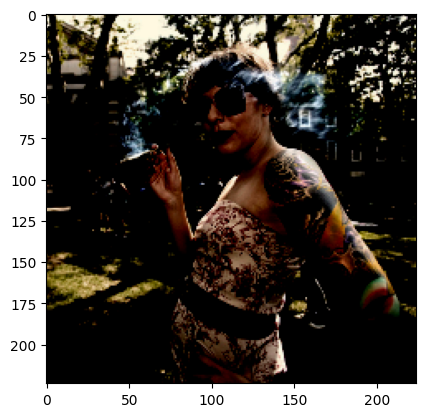

In [9]:
# Example of colored picture
plt.imshow(imgs_for_output[0])

In [11]:
# Split input images
train_input_images, test_input_images = train_test_split(imgs_for_input, test_size=0.2, random_state=42)

# Split output images
train_output_images, test_output_images = train_test_split(imgs_for_output, test_size=0.2, random_state=42)

Now make model and train it. 

In [12]:
# Construct some simple CNN model
model_simple = Sequential()
model_simple.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model_simple.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model_simple.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model_simple.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-8), loss=tf.keras.losses.MeanSquaredError())

In [13]:
model_simple.fit(train_input_images, train_output_images, epochs = 5, batch_size = 64)

Epoch 1/5
32/32 [==============================] - 103s 3s/step - loss: 0.3251
Epoch 2/5
32/32 [==============================] - 94s 3s/step - loss: 0.3125
Epoch 3/5
32/32 [==============================] - 98s 3s/step - loss: 0.3098
Epoch 4/5
32/32 [==============================] - 95s 3s/step - loss: 0.3088
Epoch 5/5
32/32 [==============================] - 101s 3s/step - loss: 0.3083


In [14]:
predicted_images = model_simple.predict(test_input_images)

16/16 [==============================] - 9s 517ms/step


Examples of original and predicted colored images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


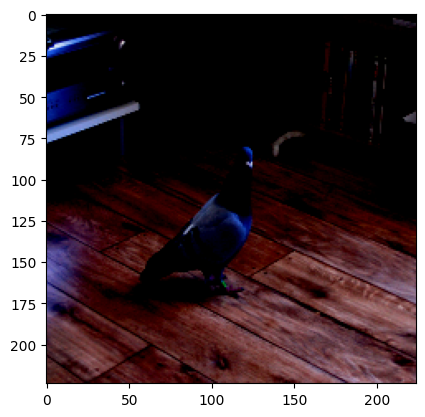

In [15]:
plt.imshow(test_output_images[0])

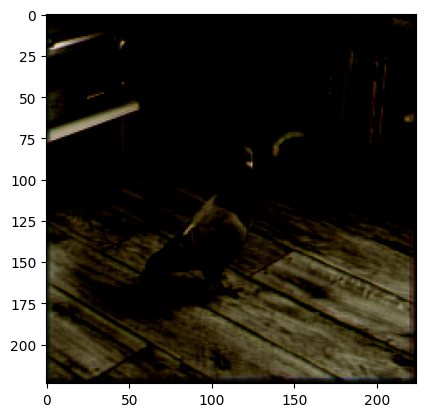

In [16]:
plt.imshow(predicted_images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


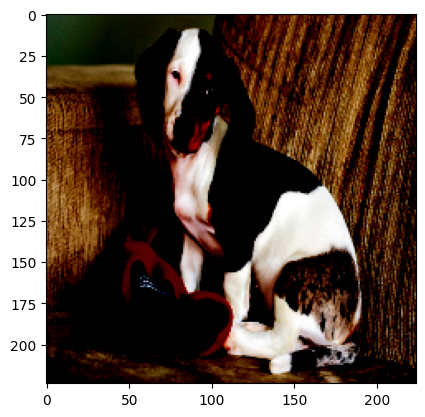

In [17]:
plt.imshow(test_output_images[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


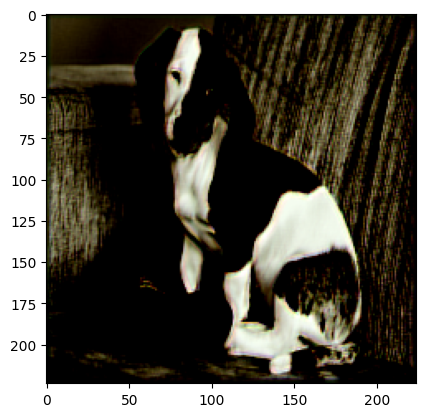

In [18]:
plt.imshow(predicted_images[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


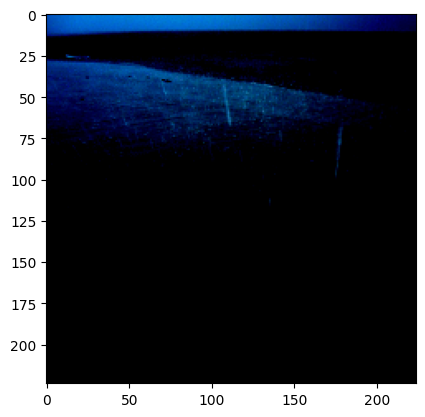

In [19]:
plt.imshow(test_output_images[2])

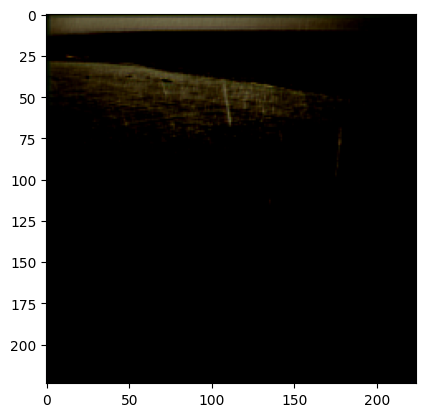

In [20]:
plt.imshow(predicted_images[2])

For our dataset and model, we observe that the predicted images predominantly exhibit a yellowish color palette.